In [35]:
import sqlite3
import requests
import json
import warnings
import re
from datetime import datetime, date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
def get_marketdata(isin, try_counter = 1):
    # Подключение к API мосбиржи

    # Проверка количества попыток для подключения (максимум 4)
    if try_counter >= 4:
        warnings.warn("Попытки подключения к API мосбиржи оказались неудачными", RuntimeWarning)
        return
    
    url = f"https://iss.moex.com/iss/engines/stock/markets/bonds/securities/{isin}.json"
    response = requests.get(url)  # запрос данных по url

    # Проверка успешного подключения
    if response.status_code != 200:
        warnings.warn("Не удалось подключиться к API мосбиржи", RuntimeWarning)

        # Выполняем повторное подключение
        get_marketdata(isin, try_counter = try_counter + 1)
        return
    
    data = response.json()  # Преобразование ответа в JSON

    # Получение данных из блока securities
    inf = get_securities_block(isin, data)

    # Получение данных из блока marketdata
    inf1 = get_marketdata_block(inf, isin, data)

    # Получение данных из блока marketdata_yields
    inf2 = get_marketdata_yields_block(inf1, isin, data)

    if inf2:
        # Сохранение в базу данных
        db = DatabaseManager('bonds.db')
        db.insert_dict("bonds_info", inf2)
    else:
        print(f"Информация по {isin} не найдена")


In [3]:
def get_securities_block(isin, data) -> dict:
    # Получение данных из блока securities

    try:
        # Возможно имеет смысл добавить обработку try except для каждого получаемого поля
        
        inf = {}
        # SECID (ISIN)
        inf[data["securities"]["columns"][0]] = data["securities"]["data"][0][0]
        inf[data["securities"]["columns"][0]] = data["securities"]["data"][0][0]
        
        # get boardid (режим торгов)
        inf[data["securities"]["columns"][1]] = data["securities"]["data"][0][1]
    
        # значение купона
        inf[data["securities"]["columns"][5]] = data["securities"]["data"][0][5]
    
        # дата следующего купона
        inf[data["securities"]["columns"][6]] = data["securities"]["data"][0][6]
    
        # Lotsize (лотность)
        inf[data["securities"]["columns"][9]] = data["securities"]["data"][0][9]
    
        # facevalue (номинал)
        inf[data["securities"]["columns"][10]] = data["securities"]["data"][0][10]
    
        # status
        inf[data["securities"]["columns"][12]] = data["securities"]["data"][0][12]
    
        # matdate (Дата погашения)
        inf[data["securities"]["columns"][13]] = data["securities"]["data"][0][13]
    
        # COUPONPERIOD 
        inf[data["securities"]["columns"][15]] = data["securities"]["data"][0][15]
    
        # ISSUESIZE
        inf[data["securities"]["columns"][16]] = data["securities"]["data"][0][16]
    
        # SECNAME
        inf[data["securities"]["columns"][19]] = data["securities"]["data"][0][19]
    
        # FACEUNIT (валюта)
        inf[data["securities"]["columns"][25]] = data["securities"]["data"][0][25]
    
        # ISIN
        inf[data["securities"]["columns"][28]] = data["securities"]["data"][0][28]
    
        # COUPONPERCENT (купон в процентах)
        inf[data["securities"]["columns"][35]] = data["securities"]["data"][0][35]
    
        # OFFERDATE (дата оферты)
        inf[data["securities"]["columns"][36]] = data["securities"]["data"][0][36]

    except:
        print(f"Ошибка с ISIN {isin} в блоке securities")
        warnings.warn(f"Информация в блоке securities по бумаге {isin} не найдена", UserWarning)

    finally:
        return inf

In [4]:
def get_marketdata_block(inf, isin, data) -> dict:
    # Получение данных из блока marketdata

    try:
        # LAST (последняя цена)
        inf[data["marketdata"]["columns"][11]] = data["marketdata"]["data"][0][11]
    
        # VALUE (должна быть цена в рублях)
        inf[data["marketdata"]["columns"][15]] = data["marketdata"]["data"][0][15]
    
        # YIELD (YTM)
        inf[data["marketdata"]["columns"][16]] = data["marketdata"]["data"][0][16]
    
        # VALUE_USD (цена в долларах)
        inf[data["marketdata"]["columns"][17]] = data["marketdata"]["data"][0][17]
    
        # DURATION (в днях)
        inf[data["marketdata"]["columns"][36]] = data["marketdata"]["data"][0][36]
    
        # YIELDTOOFFER (доходность к оферте)
        inf[data["marketdata"]["columns"][56]] = data["marketdata"]["data"][0][56]

    except:
        print(f"Ошибка с ISIN {isin} в блоке marketdata")
        warnings.warn(f"Информация в блоке marketdata по бумаге {isin} не найдена", UserWarning)
        
    finally:
        return inf

In [5]:
def get_marketdata_yields_block(inf, isin, data) -> dict:
    # Получение данных из блока marketdata_yields

    try:
        # YIELDDATE (дата на которую рассчитывается доходность)
        inf[data["marketdata_yields"]["columns"][3]] = data["marketdata_yields"]["data"][0][3]
    
        # YIELDDATETYPE (тип события которое будет в дату на которую рассчитывается доходность)
        inf[data["marketdata_yields"]["columns"][5]] = data["marketdata_yields"]["data"][0][5]
    
        # EFFECTIVEYIELD (эффективная доходность)
        inf[data["marketdata_yields"]["columns"][6]] = data["marketdata_yields"]["data"][0][6]
    
        # ZSPREADBP (z спред)
        inf[data["marketdata_yields"]["columns"][8]] = data["marketdata_yields"]["data"][0][8]
    
        # GSPREADBP (g спред)
        inf[data["marketdata_yields"]["columns"][9]] = data["marketdata_yields"]["data"][0][9]
        
    except:
        print(f"Ошибка с ISIN {isin} в блоке marketdata_yields")
        warnings.warn(f"Информация в блоке marketdata_yields по бумаге {isin} не найдена", UserWarning)

    finally:
        return inf

In [11]:
class DatabaseManager:
    def __init__(self, db_path):
        self.db_path = db_path
    
    def __enter__(self):
        self.conn = sqlite3.connect(self.db_path)
        return self.conn.cursor()
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        if exc_type is None:
            self.conn.commit()
        else:
            self.conn.rollback()
        self.conn.close()

    def is_date_string(self, value):
        """
        Проверяет, является ли строка датой в формате 'YYYY-MM-DD'
        """
        if not isinstance(value, str):
            return False
        
        # Проверка формата YYYY-MM-DD
        pattern = r'^\d{4}-\d{2}-\d{2}$'
        if re.match(pattern, value):
            return True
        
        return False
    
    def insert_dict(self, table_name, data_dict):
        with self as cursor:
            # Проверяем существование таблицы
            cursor.execute("""
                SELECT name FROM sqlite_master 
                WHERE type='table' AND name=?
            """, (table_name,))
            
            table_exists = cursor.fetchone() is not None
            if not table_exists:
                # Создаем таблицу на основе ключей словаря
                columns = []
                for key, value in data_dict.items():
                    if isinstance(value, int):
                        col_type = 'INTEGER'
                    elif isinstance(value, float):
                        col_type = 'REAL'
                    elif self.is_date_string(value):
                        col_type = 'TEXT'
                    else:
                        col_type = 'TEXT'
                    columns.append(f'{key} {col_type}')
                
                create_query = f'''
                    CREATE TABLE {table_name} (
                        id INTEGER PRIMARY KEY AUTOINCREMENT,
                        {", ".join(columns)}
                    )
                '''
                cursor.execute(create_query)
        
            columns = ', '.join(data_dict.keys())
            placeholders = ':' + ', :'.join(data_dict.keys())
            
            # Выполняем запрос - SQLite сам преобразует None в NULL
            cursor.execute(f'''
                INSERT INTO {table_name} ({columns})
                VALUES ({placeholders})
            ''', data_dict)

    def delete_table(self, table_name):
        "Удаление таблицы"
        with self as cursor:
            
            # Проверяем существование таблицы
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name=?", (table_name,))
            if cursor.fetchone():
                # Удаляем таблицу
                cursor.execute(f"DROP TABLE {table_name}")

    def fetch_data_from_sqlite(self, df, keys_list, table_name):
        """Получение данных об облигациях из SQLite по списку ISIN"""

        # Проверка что список ISIN не пустой
        if not keys_list:
            print("Передан пустой список ключей")
            return

        with self as cursor:
            placeholders = ','.join(['?'] * len(keys_list))

            query = f"""
            SELECT *
            FROM {table_name} 
            WHERE isin IN ({placeholders})
            """

            # Если self возвращает курсор, получаем соединение из него
            if hasattr(cursor, 'connection'):
                conn = cursor.connection
            else:
                # Или предполагаем, что cursor это соединение
                conn = cursor

            result_df = pl.read_database(query, conn, execute_options={'parameters': keys_list})
            
            result_df = df.join(result_df, on="ISIN", how="inner")

            return result_df 

In [13]:
def get_currency(try_counter=1):

    # Проверка количества попыток для подключения (максимум 4)
    if try_counter >= 4:
        warnings.warn("Попытки подключения к API мосбиржи оказались неудачными", RuntimeWarning)
        return
    
    url = "https://iss.moex.com/iss/engines/currency/markets/index/securities.json"
    response = requests.get(url)  # запрос данных по url

    # Проверка успешного подключения
    if response.status_code != 200:
        warnings.warn("Не удалось подключиться к API мосбиржи", RuntimeWarning)

        # Выполняем повторное подключение
        get_marketdata(isin, try_counter = try_counter + 1)
        return
    
    data = response.json()  # Преобразование ответа в JSON

    # количество возможных для парсинга валют
    str_number = min(len(data['securities']['data']), len(data['marketdata']['data']))

    inf = {}

    # проходим по всем валютам
    for i in range(str_number):
        
        try:
            # BOARDID
            inf[data['securities']['columns'][0]] = data['securities']['data'][i][0]
        
            # SECID
            inf[data['securities']['columns'][1]] = data['securities']['data'][i][1]
        
            # SHORTNAME
            inf[data['securities']['columns'][2]] = data['securities']['data'][i][2]
        
            # LATNAME
            inf[data['securities']['columns'][3]] = data['securities']['data'][i][3]
        
            # NAME
            inf[data['securities']['columns'][4]] = data['securities']['data'][i][4]
        
            # TRADEDATE
            inf[data['marketdata']['columns'][2]] = data['marketdata']['data'][i][2]
        
            # TIME
            inf[data['marketdata']['columns'][3]] = data['marketdata']['data'][i][3]
        
            # LASTVALUE
            inf[data['marketdata']['columns'][4]] = data['marketdata']['data'][i][4]
        except:
            print(f"Ошибка при загрузке валют")
            warnings.warn(f"Информация не найдена", UserWarning)
            return inf
    
        # Сохранение в базу данных
        db = DatabaseManager('bonds.db')
        db.insert_dict("currency", inf)
        
    print("Данные о валютах обновлены")

In [55]:
get_currency()

{'BOARDID': 'FIXI', 'SECID': 'USDKZTFIXME', 'SHORTNAME': 'USDKZTFIXME', 'LATNAME': 'MOEX USD/KZT FX FIXING', 'NAME': 'Фиксинг доллар США/казахстанский тенге Московской Биржи', 'TRADEDATE': '2025-10-14', 'TIME': '12:30:00', 'LASTVALUE': 539.0608}


In [15]:
import polars as pl

In [16]:
def portfolio_upload(path="bonds.xlsx"):
    # Загрузка портфеля облигаций из эксель файла. Файл содержит 2 столбца: ISIN'ы и доля каждого isin
    try:
        df = pl.read_excel(path)
    except IOError as e:
        print(f"Не найден файл по пути {path}")
        raise e

    try:
        df.cast({'Доля' : pl.Float32})
    except:
        print("В столбце 'Доля' должны быть только числовые значения")
        raise ValueError

    if len(df.columns) != 2:
        print("Файл эксель должен состоять из 2 столбцов: 'ISIN' (строковое) и 'Доля' (float) каждого из ISIN в портфеле")
        return

    if round(df['Доля'].sum(), 3) > 1:
        print("!ПРЕДУПРЕЖЕДНИЕ!")
        print("Доля бумаг больше 100%")

    # Подключение к базе данных
    db = DatabaseManager('bonds.db')
    
    # Удаление старой таблицы с данными по облигациям
    db.delete_table("bonds_info")
    
    # обновление данных по каждому ISIN в базе данных
    for row in df.iter_rows():
        get_marketdata(row[0])

    # Уникальные ISIN из датафрейма
    unique_isins = df["ISIN"].unique().to_list()

    bond_data_df = db.fetch_data_from_sqlite(df, unique_isins, "bonds_info")
    
    df = dataframe_proceccing(bond_data_df,
                     date_columns=['NEXTCOUPON', 'MATDATE', 'YIELDDATE', 'OFFERDATE'],
                     drop_columns=['SECID', 'BOARDID', 'id', 'ISSUESIZE'])

    # Уникальные валюты в портфеле
    unique_currency = df['FACEUNIT'].unique().to_list()

    # Для каждой валюты вычисляем характеристики портфеля
    for currency in unique_currency: # сюда поставить unique_currency вместо list
        filtered_df = df.filter(pl.col('FACEUNIT') == currency)
        if round(filtered_df['Доля'].sum(), 5) > 0:
            # print(filtered_df)
            portfolio_info(filtered_df, currency)
            
    
    # portfolio_info(df)

    # return df

In [19]:
def dataframe_proceccing(df, date_columns:list = [], drop_columns=[]):
    # обработка датафрейма

    today = date.today()
    
    try:
        for column in date_columns:
            if column:
                df = df.cast({column : pl.Date})
                # Добавление столбцов: дата - текущая дата для всех столбцов где есть даты
                delta_days = (pl.Series(df[column]) - today).alias(f"{column}_delta")
                column_index = df.get_column_index(column)
                df.insert_column(column_index+1, delta_days)
                
    except:
        warnings.warn(f"Возникла ошибка с трансформацией строки в дату.", UserWarning)
        raise

    try:
        for column in drop_columns:
            df = df.drop(column)
    except:
        warnings.warn(f"Возникла ошибка с при удалении столбца.", UserWarning)

    return df

In [58]:
def get_riskoff_yeilds(currency):
    if currency == 'RUB':
        df = rub_yield()
        return df
    elif currency == 'USD':
        df = usd_yield()
        return df
    # df = rub_yield()
    

In [40]:
def rub_yield():
    # Получение безрисковых ставок с api мосбиржи
    today = date.today()
    day_counter = 0

    url = f'https://iss.moex.com/iss/engines/stock/zcyc.json?date={today}'
    response = requests.get(url)  # запрос данных по url  
    data = response.json()  # Преобразование ответа в JSON

    # если выходной или праздник, то в этот день нет данных - пропускаем его и идем дальше
    while not data['yearyields']['data'] and day_counter < 30:
        today = today - timedelta(days=1)
        url = f'https://iss.moex.com/iss/engines/stock/zcyc.json?date={today}'
        response = requests.get(url)  # запрос данных по url  
        data = response.json()  # Преобразование ответа в JSON

    # Названия столбцов
    schema = data['yearyields']['columns']

    # Данные
    lsts = [[], [], [], []]

    for i in range(len(data['yearyields']['data'])):
        lsts[0].append(data['yearyields']['data'][i][0])
        lsts[1].append(data['yearyields']['data'][i][1])
        lsts[2].append(data['yearyields']['data'][i][2])
        lsts[3].append(data['yearyields']['data'][i][3])

    # Создание датафрейма polars
    df = pl.DataFrame(lsts, schema=['tradedate', 'tradetime', 'period', 'value'], orient="col")

    # обработка датафрейма (преобразование в дату и удаление лишних столбцов)
    df = dataframe_proceccing(df, date_columns=['tradedate'], drop_columns=['tradetime', 'tradedate_delta'])

    return df

In [50]:
def usd_yield():
    # Тикеры для основных сроков
    tickers = {
        '0.25': '^IRX',
        '0.50': '^IRX',
        '1.00': '^TNX',   
        '2.00': '^TNX',
        '5.00': '^FVX',
        '10.00': '^TNX',
        '30.00': '^TYX'
    }
    data_records = []
    
    for maturity, ticker in tickers.items():
        try:
            bond_data = yf.Ticker(ticker)
            hist = bond_data.history(period='1d')
            
            if not hist.empty:
                current_yield = hist['Close'].iloc[-1]
                
                data_records.append({
                    'period': maturity,
                    'ticker': ticker,
                    'value': current_yield,
                    'date': datetime.now().date(),
                })
            #     print(f"✅ {maturity}: {current_yield:.3f}%")
            # else:
            #     print(f"❌ Нет данных для {maturity}")
                
        except Exception as e:
            print(f"❌ Ошибка для {maturity}: {e}")
    
    # Создаем DataFrame Polars
    if data_records:
        df = pl.DataFrame(data_records)
        return df
        # print(df)
    else:
        return None

In [44]:
def freerisk_plot(weighted_YTM, weighted_maturity_date, currency):
    # Построение графика с эффективной доходностью портфеля относительно
    # безрисковой доходности

    df = get_riskoff_yeilds(currency)
    
    # Основной график с настройками
    ax = sns.lineplot(data=df, x='period', y='value',
                     markers=True, linewidth=2, marker='o',
                     markersize=6, color='#3498DB',
                     markerfacecolor='white',  # Белая заливка маркеров
                     markeredgewidth=2, markeredgecolor='#3498DB',
                     label='Безрисковая доходность')
    
    # Добавляем специальную точку
    special_point = plt.scatter(x=weighted_YTM, y=weighted_maturity_date, 
                               color='#E74C3C', s=100, zorder=5,
                               edgecolors='black', linewidth=2,
                               label='Портфель')
    
    # Настройки оформления
    plt.title('Доходность портфеля на бизрисковой кривой', 
              fontsize=14, fontweight='bold', pad=25)
    plt.xlabel('Срок, лет', fontsize=14, labelpad=10)
    plt.ylabel('Эффективная доходность, %', fontsize=14, labelpad=10)
    
    # Улучшаем сетку и внешний вид
    plt.grid(True, alpha=0.4, linestyle='--')
    plt.legend(fontsize=12, framealpha=0.9)
    
    # Убираем лишние рамки
    sns.despine(left=True, bottom=True)
    
    plt.tight_layout()
    plt.show()

In [46]:
def portfolio_info(df, currency):
    # Расчет показателей портфеля

    weighted_YTM = 0.0
    weighted_duration = 0.0
    weighted_couponperid = 0.0
    weighted_couponpercent = 0.0
    weighted_yield = 0.0
    weighted_maturity_date = 0.0

    # пересчет долей
    sum_share = df['Доля'].sum()
    df = df.with_columns(
        (pl.col('Доля') / sum_share).alias('Доля')  # то же имя столбца
    )


    for row in df.iter_rows():
        # взвешенный купонный период
        weighted_couponperid += row[1] * row[10]

        # взвешенный YTM
        weighted_YTM += row[1] * row[25]

        # взвешенная дюрация
        weighted_duration += row[1] * row[20]

        # взвешенный процент по купонам
        weighted_couponpercent += row[1] * row[13]

        # взвешенная доходность
        weighted_yield += row[1] * row[18]

        # Взвешенный срок до погашения
        weighted_maturity_date += row[1] * (row[9].total_seconds() / 86400)

        # # Взвешенный срок до события
        # weighted_maturity_date += row[1] * (row[7].total_seconds() / 86400)       

    print(f"Информация по портфелю в валюте {currency}")
    print(f"YTM портфеля: {round(weighted_YTM, 2)}%")
    print(f"Доходность портфеля: {round(weighted_yield, 2)}%")
    print(f"Дюрация портфеля: {round(weighted_duration, 2)} дней")
    print(f"Взвешенный процент по купонам: {round(weighted_couponpercent, 2)}")
    print(f"Взвешенный купонный период по портфелю: {round(weighted_couponperid, 2)} дней")
    print(f"Взвешенный срок до погашения: {round(weighted_maturity_date, 2)} дней")
    print(f"Взвешенный срок до погашения: {round(weighted_maturity_date / 365, 3)} лет")

    freerisk_plot(weighted_maturity_date / 365, weighted_YTM, currency)

Информация по портфелю в валюте USD
YTM портфеля: 10.84%
Доходность портфеля: 10.84%
Дюрация портфеля: 756.85 дней
Взвешенный процент по купонам: 11.85
Взвешенный купонный период по портфелю: 40.2 дней
Взвешенный срок до погашения: 870.28 дней
Взвешенный срок до погашения: 2.384 лет


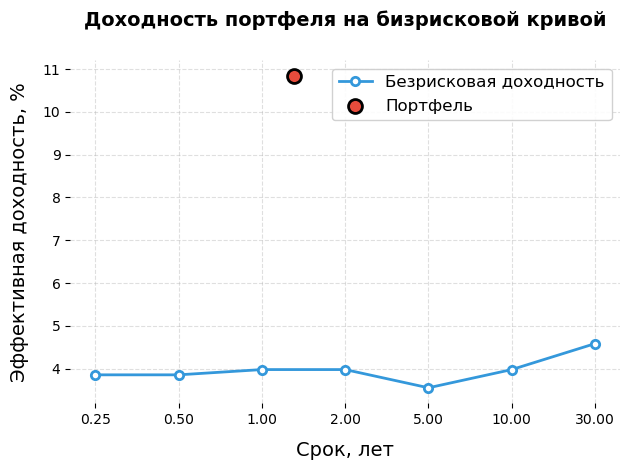

Информация по портфелю в валюте CNY
YTM портфеля: 11.52%
Доходность портфеля: 11.52%
Дюрация портфеля: 561.09 дней
Взвешенный процент по купонам: 12.17
Взвешенный купонный период по портфелю: 30.0 дней
Взвешенный срок до погашения: 626.65 дней
Взвешенный срок до погашения: 1.717 лет


ValueError: Could not interpret value `period` for `x`. Value is a string, but `data` was not passed.

In [60]:
portfolio_upload()

YTM портфеля: 11.43%
Доходность портфеля: 11.43%
Дюрация портфеля: 718.14 дней
Взвешенный процент по купонам: 11.73
Взвешенный купонный период по портфелю: 44.35 дней
Взвешенный срок до погашения: 819.38 дней
Взвешенный срок до погашения: 2.245 лет


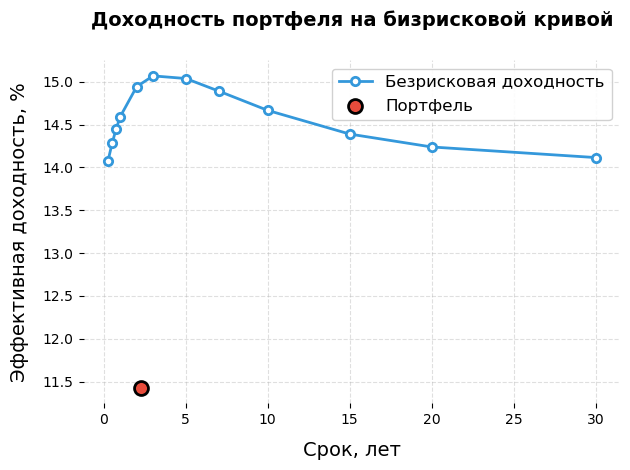

In [29]:
# Для дальнейшей работы
df = portfolio_upload()